<a href="https://colab.research.google.com/github/dsp196/Pneumonia_detection/blob/main/Pneumonia_Detection102.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
#change permission
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.28G/2.29G [00:29<00:00, 62.5MB/s]
100% 2.29G/2.29G [00:29<00:00, 83.3MB/s]


In [ ]:
from zipfile import ZipFile
file_name  = "chest-xray-pneumonia.zip"

In [ ]:
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau ,EarlyStopping,ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [ ]:
image_size =180
batch_size =64
epochs =30

In [ ]:
base_dir = '/content/chest_xray/'
pneumonia_files = glob.glob(base_dir + '/**/PNEUMONIA/*.jpeg')
normal_files = glob.glob(base_dir + '/**/NORMAL/*.jpeg')

In [ ]:
print('pneumonia files : {}'.format(len(pneumonia_files)))
print('normal_files : {}'.format(len(normal_files)))

pneumonia files : 4273
normal_files : 1583


In [ ]:
# Data Splitting 
train_pneumonia , test_pneumonia = train_test_split(pneumonia_files,test_size = 0.2)
train_pneumonia , val_pneumonia = train_test_split(train_pneumonia,test_size =0.2)

In [ ]:
train_normal, test_normal = train_test_split(normal_files , test_size = 0.2)
train_normal , val_normal = train_test_split(train_normal , test_size = 0.2)

In [ ]:
print('Pneumonia files have {0} training examples ,{1} testing examples ,{2} validation examples'.format(len(train_pneumonia),len(test_pneumonia),len(val_pneumonia)))
print('Normal files have {0} training examples ,{1} testing examples ,{2} validation examples'.format(len(train_normal),len(test_normal),len(val_normal)))

Pneumonia files have 2734 training examples ,855 testing examples ,684 validation examples
Normal files have 1012 training examples ,317 testing examples ,254 validation examples


In [ ]:
# adding labels (pneumonia: 1, normal: 0)
train_data = []
val_data = []
test_data = []

for sample in train_pneumonia:
    train_data.append([sample, '1'])

for sample in val_pneumonia:
    val_data.append([sample, '1'])
    
for sample in test_pneumonia:
    test_data.append([sample, '1'])
    
for sample in train_normal:
    train_data.append([sample, '0'])
    
for sample in val_normal:
    val_data.append([sample, '0'])
    
for sample in test_normal:
    test_data.append([sample, '0'])
    
# convert them into dataframes
train_df = pd.DataFrame(train_data, columns=['image', 'label'])
val_df = pd.DataFrame(val_data, columns=['image', 'label'])
test_df = pd.DataFrame(test_data, columns=['image', 'label'])

print(len(train_df), len(val_df), len(test_df))

3746 938 1172


In [ ]:
train_img_gen = ImageDataGenerator(rescale=1./255,
                                   rotation_range =10,
                                   zoom_range =0.2,
                                   width_shift_range =0.1,
                                   height_shift_range =0.1)

test_img_gen = ImageDataGenerator(
    rescale=1./255
)

val_img_gen = ImageDataGenerator(
    rescale =1./255
)

In [ ]:
train_set_gen = train_img_gen.flow_from_dataframe(train_df,x_col = 'image',y_col ='label',target_size=(image_size,image_size),batch_size=batch_size,shuffle =True ,class_mode ='binary',color_mode='grayscale')
test_set_gen  = test_img_gen.flow_from_dataframe(test_df,x_col = 'image',y_col = 'label',target_size= (image_size,image_size),batch_size=1,class_mode='binary',shuffle =False,color_mode='grayscale')
val_set_gen = val_img_gen.flow_from_dataframe(val_df,x_col = 'image',y_col ='label',target_size=(image_size,image_size),batch_size =batch_size,shuffle=True,class_mode='binary',color_mode ='grayscale')

Found 3746 validated image filenames belonging to 2 classes.
Found 1172 validated image filenames belonging to 2 classes.
Found 938 validated image filenames belonging to 2 classes.


In [ ]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(32,(3,3),input_shape = (180,180,1),activation='relu',padding ='same'),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same'),
                                    tf.keras.layers.MaxPooling2D((2,2)),
                                    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
                                    tf.keras.layers.MaxPooling2D((2,2)),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
                                    tf.keras.layers.MaxPooling2D((2,2)),
                                    tf.keras.layers.Dropout(0.3),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(64,activation = 'relu'),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(1,activation = 'sigmoid'),
])

In [ ]:
#METRICS =[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.Accuracy(),tf.keras.metrics.Precision(name = 'precision'),tf.keras.metrics.Recall(name ='recall')]

In [ ]:
model.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics=['accuracy'])

In [ ]:
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 3, 
                                 verbose=1,factor=0.5, min_lr=0.000001)

In [ ]:
history = model.fit_generator(train_set_gen,
                              steps_per_epoch=len(train_set_gen),
                              epochs=epochs,
                              validation_data=val_set_gen,
                              validation_steps=len(val_set_gen),
                              callbacks=[lr_reduction])

Epoch 1/30
59/59 [==============================] - 44s 745ms/step - loss: 0.4022 - accuracy: 0.7723 - val_loss: 0.3462 - val_accuracy: 0.8635
Epoch 2/30
59/59 [==============================] - 43s 727ms/step - loss: 0.3395 - accuracy: 0.8449 - val_loss: 0.2884 - val_accuracy: 0.8849
Epoch 3/30
59/59 [==============================] - 43s 728ms/step - loss: 0.3324 - accuracy: 0.8580 - val_loss: 0.2563 - val_accuracy: 0.9296
Epoch 4/30
59/59 [==============================] - 43s 725ms/step - loss: 0.3145 - accuracy: 0.8716 - val_loss: 0.3090 - val_accuracy: 0.8539
Epoch 5/30
59/59 [==============================] - 43s 724ms/step - loss: 0.2880 - accuracy: 0.8905 - val_loss: 0.2152 - val_accuracy: 0.9339
Epoch 6/30
59/59 [==============================] - 43s 725ms/step - loss: 0.2844 - accuracy: 0.8900 - val_loss: 0.2012 - val_accuracy: 0.9350
Epoch 7/30
59/59 [==============================] - 43s 727ms/step - loss: 0.2628 - accuracy: 0.9031 - val_loss: 0.2144 - val_accuracy: 0.9360

In [ ]:
Predict_score  = model.evaluate(test_set_gen)
print(Predict_score)

1172/1172 [==============================] - 12s 10ms/step - loss: 0.1854 - accuracy: 0.9275
[0.18535558879375458, 0.9274743795394897]


In [ ]:
model.save('Cnn_xray_103.h5')

In [ ]:
model.save_weights('Cnn_xray_103_weights.h5')

In [ ]:
model_json = model.to_json()
with open("Cnn_xray_103.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
predictions = model.predict_classes(test_set_gen)

cm = confusion_matrix(test_set_gen.classes, predictions)

In [ ]:
cm_pd = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

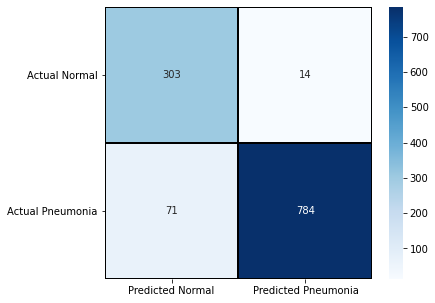

In [ ]:
plt.figure(figsize = (6,5))
sns.heatmap(cm_pd,cmap= "Blues", linecolor = 'black' , 
            linewidth = 1 , annot = True, fmt='',
            xticklabels = ['Predicted Normal', 'Predicted Pneumonia'],
            yticklabels = ['Actual Normal', 'Actual Pneumonia'])
plt.yticks(rotation=0)
plt.show()